# Combined  Model (XGBoost Undersampling + XGBoost Regression)


In [1]:
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shap
import imblearn
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import cm
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from utils import get_training_dataset

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
# Read csv file and import to df
df = get_training_dataset()
df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,NaN,1.018526,...,2.699781,5.762712,3445.709753,1,0.0,0.00,1.00,0.000000,0.0,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,1.579400,...,4.585088,12.799127,8602.645832,1,0.0,0.00,1.00,0.000000,0.0,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.551764,...,1.527495,8.833333,5084.012925,1,0.0,0.01,0.99,197.339034,0.0,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.107949,...,11.677657,17.530431,55607.865950,1,0.0,0.31,0.69,4970.477311,0.0,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,3.538881,...,17.074011,31.931338,35529.342507,1,0.0,0.77,0.23,12408.594656,0.0,0.0


In [4]:
# Fill NaNs with average estimated value of 'rwi'
df["rwi"].fillna(df["rwi"].mean(), inplace=True)

# Set any values >100% to 100%,
for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] > 100:
        df.at[i, "percent_houses_damaged"] = float(100)

In [5]:
# Remove zeros from wind_speed
df = (df[(df[["wind_speed"]] != 0).any(axis=1)]).reset_index(drop=True)
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,12.896581,7.450346,74.625539,34.629550,42.218750,5303.659490,1,0.00,0.00,1.00,0.000000,0.0,0.0
1,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,14.070741,6.514647,68.681417,25.475388,72.283154,61015.543599,1,0.00,0.14,0.86,276.871504,0.0,0.0
2,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,19.758682,10.940700,104.453163,54.353996,102.215198,66707.438070,1,0.00,0.11,0.89,448.539453,0.0,0.0
3,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,11.499097,6.901584,59.798108,31.814048,58.988877,53841.050168,1,0.00,0.12,0.88,2101.708435,0.0,0.0
4,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,13.866633,6.528689,65.655280,25.976413,111.386527,87378.257957,1,0.07,0.46,0.47,11632.726327,0.0,0.0


In [6]:
# Define bins for data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)

In [7]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    38901
(9e-05, 1.0]        7232
(1.0, 10.0]         2552
(10.0, 50.0]         925
(50.0, 101.0]        144
Name: percent_houses_damaged, dtype: int64

In [8]:
print(samples_per_bin2)
print(binsP2)

[38901  7232  2552   925   144]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [9]:
bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)

In [10]:
y_input_strat = bin_index2

In [11]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["percent_houses_damaged"]

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [13]:
# Define train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    df["percent_houses_damaged"],
    test_size=0.2,
    stratify=y_input_strat,
)

## First step is to train XGBoost Regression model for train data

In [14]:
# XGBoost Reduced Overfitting
xgb = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    colsample_bytree=0.8,
    gamma=3,
    eta=0.01,
    importance_type="gain",
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=4,
    min_child_weight=1,
    missing=1,
    n_estimators=100,
    early_stopping_rounds=10,
    n_jobs=1,
    nthread=None,
    objective="reg:squarederror",
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=0.8,
    verbosity=1,
    eval_metric=["rmse", "logloss"],
    random_state=0,
)

eval_set = [(X_test, y_test)]
xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[14:08:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                              OLS Regression Results                              
Dep. Variable:     percent_houses_damaged   R-squared:                       0.205
Model:                                OLS   Adj. R-squared:                  0.204
Method:                     Least Squares   F-statistic:                     602.1
Date:                    Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                            14:08:49   Log-Likelihood:            -1.1650e+05
No. Observations:                   39803   AIC:                 

In [15]:
# Make prediction on train and test data
y_pred_train = xgb.predict(X_train)
y_pred = xgb.predict(X_test)

In [16]:
# Calculate RMSE in total

mse_train_idx = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train_idx)

mse_idx = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_idx)

# print(f"RMSE_test_in_total: {rmse:.2f}")
print(f"RMSE_train_in_total: {rmse_train:.2f}")

RMSE_train_in_total: 2.60


In [17]:
# Calculate RMSE per bins

bin_index_test = np.digitize(y_test, bins=binsP2)
bin_index_train = np.digitize(y_train, bins=binsP2)

for bin_num in range(1, 6):

    # Estimation of RMSE for train data
    mse_train_idx = mean_squared_error(
        y_train[bin_index_train == bin_num], y_pred_train[bin_index_train == bin_num]
    )
    rmse_train = np.sqrt(mse_train_idx)

    # Estimation of RMSE for test data
    mse_idx = mean_squared_error(
        y_test[bin_index_test == bin_num], y_pred[bin_index_test == bin_num]
    )
    rmse = np.sqrt(mse_idx)

    # print(f"RMSE_test: {rmse:.2f}")
    print(f"RMSE_train: {rmse_train:.2f}")

RMSE_train: 0.78
RMSE_train: 1.62
RMSE_train: 3.92
RMSE_train: 12.91
RMSE_train: 26.47


## Second step is to train XGBoost Binary model for same train data

In [18]:
# Define a threshold to separate target into damaged and not_damaged
thres = 10.0

for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] >= thres:
        df.at[i, "binary_damage"] = 1
    else:
        df.at[i, "binary_damage"] = 0

df["binary_damage"] = df["binary_damage"].astype("int")
# df = df.drop("percent_houses_damaged", axis=1)
df

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,...,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years,binary_damage
0,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,12.896581,7.450346,74.625539,...,42.218750,5303.659490,1,0.00,0.000000,1.000000,0.000000,0.0,0.000000,0
1,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,14.070741,6.514647,68.681417,...,72.283154,61015.543599,1,0.00,0.140000,0.860000,276.871504,0.0,0.000000,0
2,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,19.758682,10.940700,104.453163,...,102.215198,66707.438070,1,0.00,0.110000,0.890000,448.539453,0.0,0.000000,0
3,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,11.499097,6.901584,59.798108,...,58.988877,53841.050168,1,0.00,0.120000,0.880000,2101.708435,0.0,0.000000,0
4,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,13.866633,6.528689,65.655280,...,111.386527,87378.257957,1,0.07,0.460000,0.470000,11632.726327,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49749,MOLAVE,8.011792,255.535258,2.256250,1.056771,41.979062,-0.742000,10.019319,7.973423,51.666178,...,39.018519,1929.419748,1,0.01,0.000000,0.990000,330.215768,0.0,1.143833,0
49750,MOLAVE,7.617460,266.645258,2.170833,0.933854,1625.734579,-0.096571,3.962696,3.907937,20.118420,...,25.042969,45965.284119,1,0.05,0.190000,0.760000,5409.607943,0.0,1.143833,0
49751,MOLAVE,7.170117,277.755258,1.918750,0.833333,624.597557,0.190000,3.952812,3.697735,21.629590,...,17.537129,14744.712453,1,0.01,0.020000,0.970000,5378.401365,0.0,1.143833,0
49752,MOLAVE,6.834925,288.864374,3.747917,1.161310,18.445345,-0.320000,4.054233,2.507445,24.421430,...,15.389474,5376.583753,1,0.00,0.027273,0.972727,914.677196,0.0,1.143833,0


In [19]:
x_train_idx = X_train.index
x_train_idx

Int64Index([41651, 12543, 20034, 35310, 15876,  5234, 14689,  4935, 39760,
            26264,
            ...
            26770,  9332, 13656, 34128,  6272, 20763, 47010, 18242, 23565,
            34052],
           dtype='int64', length=39803)

In [20]:
df_train = df.loc[df.index[x_train_idx]]
df_train["original_index"] = df_train.index
df_train

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,...,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years,binary_damage,original_index
41651,PHANFONE,32.468254,57.882712,9.685417,4.733333,249.455600,-0.213039,3.358111,1.332716,18.670311,...,1530.362907,1,0.000000,0.000000,1.00,1111.611749,0.000000,0.305528,0,41651
12543,HAIYAN,17.385358,213.469248,4.781250,3.085417,43401.497480,0.760429,1.904988,1.534802,9.980537,...,14569.463788,1,0.572727,0.027273,0.40,225127.611389,0.000000,0.000000,0,12543
20034,HAGUPIT,24.608520,99.325622,4.212500,2.450521,1700.034127,-0.346167,14.000292,6.419272,66.153448,...,14757.670246,1,0.070000,0.640000,0.29,10434.281027,0.000000,0.012201,0,20034
35310,NOCK-TEN,38.494237,54.840779,18.250000,6.269792,26168.108477,0.310000,6.804420,8.881081,32.685599,...,23306.141519,1,0.550000,0.410000,0.04,119169.612010,0.017042,0.271894,0,35310
15876,JANGMI,18.618385,111.824251,12.093750,6.621875,128.421645,-0.213039,4.021015,1.517155,20.188447,...,3054.598554,1,0.010000,0.000000,0.99,539.732761,0.000000,1.355077,0,15876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20763,HAGUPIT,41.173929,49.970850,7.460417,6.883854,5268.625381,-0.398385,4.827781,5.074387,24.933197,...,57028.054958,1,0.160000,0.750000,0.09,27462.321684,8.012547,0.000000,0,20763
47010,VONGFONG,6.715344,121.354672,5.000000,3.952083,2422.442482,-0.491824,3.359071,3.253706,17.464549,...,0.000000,0,0.010000,0.990000,0.00,6594.059197,0.000000,0.698892,0,47010
18242,RAMMASUN,27.651847,105.175248,8.987500,6.626042,14044.937219,0.050467,1.871418,2.785286,10.106424,...,14181.969295,1,0.320000,0.130000,0.55,48945.290176,0.000000,0.063044,0,18242
23565,MUJIGAE,7.576301,276.526813,2.254167,1.353646,1194.111897,-0.194667,8.896846,4.933044,44.668658,...,54810.339470,1,0.000000,0.270000,0.73,9474.200825,0.000000,0.801756,0,23565


In [21]:
x_test_idx = X_test.index
x_test_idx

Int64Index([48636, 21491,  9382, 20765,  6535,  1020, 23501,  7989, 10735,
            33046,
            ...
            23133, 24910, 45543, 10787, 11979, 46849, 48464, 41687,  3247,
            13881],
           dtype='int64', length=9951)

In [22]:
df_test = df.loc[df.index[x_test_idx]]
df_test["original_index"] = df_test.index
df_test

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,...,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years,binary_damage,original_index
48636,MOLAVE,26.498247,47.597622,9.614583,5.600000,3877.910530,0.163455,17.244480,8.575215,80.971048,...,23381.978690,1,0.15,0.41,0.44,28115.954103,2.451071,0.346422,0,48636
21491,FUNG-WONG,12.364341,140.123686,13.718750,4.842187,11930.968400,0.090500,1.626739,2.273665,9.733285,...,0.000000,0,0.44,0.56,0.00,76446.610851,0.000000,0.000083,0,21491
9382,BOPHA,13.815899,194.026365,3.356250,1.687500,23965.707989,0.354947,3.570607,5.047256,18.556381,...,0.000000,0,0.33,0.67,0.00,41708.673088,0.000000,0.005814,0,9382
20765,HAGUPIT,45.540233,30.213490,9.812500,8.245833,1111.330892,-0.363250,10.587106,7.986930,51.872994,...,0.000000,0,0.00,1.00,0.00,7395.719299,0.126055,0.000000,0,20765
6535,NESAT,43.613571,16.887388,6.287500,4.995312,642.657009,-0.565467,23.451011,10.737812,117.820402,...,0.000000,0,0.00,1.00,0.00,1404.084833,0.000000,0.000000,0,6535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46849,VONGFONG,14.638464,25.886043,13.283333,5.852083,257.508997,-0.611500,14.108640,6.945721,65.307079,...,0.000000,0,0.00,1.00,0.00,1288.171667,0.000000,0.103922,0,46849
48464,MOLAVE,6.635105,278.637438,5.181250,2.923958,294.304530,-0.045000,12.085887,7.968955,61.164438,...,3087.952647,1,0.00,0.00,1.00,992.437229,0.000000,0.000000,0,48464
41687,PHANFONE,29.026699,69.886580,7.820833,5.155208,498.023819,0.075333,1.531584,1.285069,8.360776,...,2543.041679,1,0.03,0.00,0.97,1073.751323,0.066706,1.136930,0,41687
3247,FENGSHEN,30.951143,132.018229,8.091667,5.556250,61468.065043,0.860429,4.228487,4.236040,23.227299,...,44742.396844,1,0.58,0.07,0.35,408434.679471,0.000000,0.000000,0,3247


In [23]:
# get a list of all column names and exclude columns we do not need for train data
cols_to_keep = df_train.columns[
    ~df_train.columns.isin(["typhoon_name", "percent_houses_damaged", "binary_damage"])
]

In [24]:
# Define train data
X_train = df_train[cols_to_keep]
y_train = df_train["binary_damage"]

# Define test data
X_test = df_test[cols_to_keep]
y_test = df_test["binary_damage"]

In [25]:
print(Counter(y_train))

Counter({0: 38948, 1: 855})


In [26]:
# Undersampling

# Define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.7)
# Fit and apply the transform
X_train, y_train = under.fit_resample(X_train, y_train)

print(Counter(y_train))

Counter({0: 1221, 1: 855})


In [27]:
# Replace column 'original_index' with index
X_train.set_index("original_index", inplace=True)

In [28]:
X_test = X_test.drop("original_index", axis=1)

In [29]:
# Get the list of indices for train data
y_tr_idx = X_train.index
# assign the new index to the y_train
y_train.index = y_tr_idx

In [30]:
# Use XGBClassifier as a Machine Learning model to fit the data
xgb_model = XGBClassifier()

eval_set = [(X_train, y_train), (X_train, y_train)]
# eval_set = [(X_test, y_test)]
xgb_model.fit(
    X_train,
    y_train,
    eval_metric=["error", "logloss"],
    eval_set=eval_set,
    verbose=False,
)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
# Make prediction on train data
y_pred_train = xgb_model.predict(X_train)

In [32]:
# Print Confusion Matrix
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[1221,    0],
       [   0,  855]])

In [33]:
# Classification Report
print(metrics.classification_report(y_train, y_pred_train))
print(metrics.confusion_matrix(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1221
           1       1.00      1.00      1.00       855

    accuracy                           1.00      2076
   macro avg       1.00      1.00      1.00      2076
weighted avg       1.00      1.00      1.00      2076

[[1221    0]
 [   0  855]]


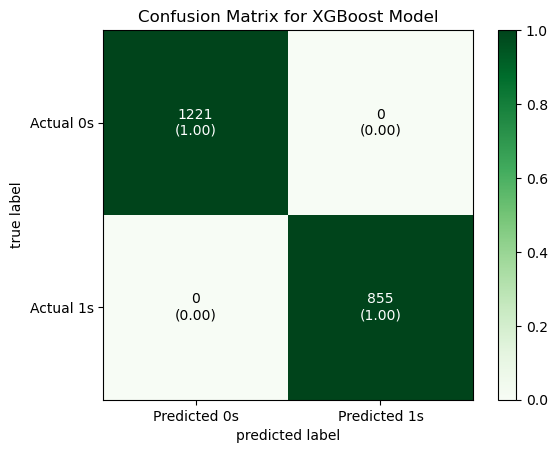

In [34]:
# Plot Confusion Matrix
fig, ax = plot_confusion_matrix(
    conf_mat=cm,
    show_absolute=True,
    show_normed=True,
    colorbar=True,
    cmap=plt.cm.Greens,
)

ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

In [35]:
X_train = X_train.reset_index(drop=True)

In [36]:
y_train = y_train.reset_index(drop=True)

In [37]:
# Add real and predicted values of train data to train_df
for i in range(len(X_train)):
    X_train.at[i, "binary_damage"] = y_train.tolist()[i]
    X_train.at[i, "predicted_value"] = y_pred_train[i]

X_train["binary_damage"] = X_train["binary_damage"].astype("int")
X_train["predicted_value"] = X_train["predicted_value"].astype("int")

X_train

,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage,predicted_value
0,13.791698,36.027193,15.612500,6.678646,269.181081,-0.444500,18.613047,8.395494,87.707141,37.071634,672.277030,0.000000,0,0.00,1.00,0.00,1723.171171,0.111517,0,0
1,23.680603,89.109036,15.185417,10.222917,4334.315700,-0.440739,3.127196,3.114014,16.307239,13.528869,48.774438,8681.831730,1,0.17,0.76,0.07,25676.307576,0.119700,0,0
2,15.060477,74.528146,1.987500,0.843750,6547.787418,0.022105,6.510432,6.229648,33.425773,28.193541,113.723299,21779.053612,1,0.40,0.52,0.08,37331.700793,0.088609,0,0
3,9.717386,251.290871,2.418750,1.659375,7391.201037,-0.012684,1.503629,1.963605,9.175381,9.376998,16.244587,0.000000,0,0.37,0.63,0.00,41128.188765,0.502159,0,0
4,36.644706,64.119895,16.227083,7.595313,256.279667,-0.351000,18.956863,9.547296,90.548007,43.164581,689.483437,0.000000,0,0.01,0.99,0.00,5546.285772,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,53.886898,6.253590,29.335417,17.279688,654.411105,-0.030000,2.619196,1.441431,15.109985,7.046451,12.205128,10841.030780,1,0.00,0.03,0.97,2750.286411,0.063721,1,1
2072,58.745087,21.762984,16.329167,6.025000,136.501695,-0.812000,7.128107,5.623399,37.207038,24.976490,210.467728,0.000000,0,0.00,1.00,0.00,1464.920388,0.000000,1,1
2073,53.426029,61.640232,11.829167,9.078125,3463.936953,-0.563850,11.955802,6.803162,57.333678,28.400566,250.835189,0.000000,0,0.07,0.93,0.00,18359.598706,0.016896,1,1
2074,58.760852,9.833055,16.343750,6.560938,986.838055,-0.515714,15.210003,8.778518,74.108770,40.966302,881.696332,0.000000,0,0.08,0.92,0.00,22196.882482,0.000000,1,1


In [38]:
X_train.index = y_tr_idx

In [39]:
# Remove rows where predicted_value == 0
X_train = X_train.drop(X_train.loc[X_train["predicted_value"] == 0].index)
X_train

,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage,predicted_value
original_index,,,,,,,,,,,,,,,,,,,,
12175,64.396609,16.814388,8.722917,4.576562,8.743381,-0.398000,30.538242,8.920952,152.396421,40.984901,1064.055324,0.000000,0,0.00,1.00,0.00,0.000000,0.797684,1,1
11823,56.384789,43.147075,7.212500,3.575000,10.213224,0.182000,8.255040,4.670409,47.898737,21.618095,32.667897,17566.027762,1,0.00,0.03,0.97,268.092992,0.000000,1,1
40057,53.368046,55.175904,15.041667,10.696354,1009.150419,-0.668083,10.832751,7.132091,54.378812,30.827395,106.654532,0.000000,0,0.00,1.00,0.00,7808.154108,2.613454,1,1
12402,58.590666,33.691405,10.747917,6.132812,80.968152,-0.213039,7.519082,3.338569,37.766973,12.649288,36.555046,2843.384966,1,0.00,0.02,0.98,329.975623,0.299293,1,1
31517,47.438166,47.701549,16.645833,8.713021,4.323614,-0.213039,16.873766,6.792982,80.112065,27.931562,468.152585,0.000000,0,0.00,1.00,0.00,1.004138,0.013477,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21024,53.886898,6.253590,29.335417,17.279688,654.411105,-0.030000,2.619196,1.441431,15.109985,7.046451,12.205128,10841.030780,1,0.00,0.03,0.97,2750.286411,0.063721,1,1
9588,58.745087,21.762984,16.329167,6.025000,136.501695,-0.812000,7.128107,5.623399,37.207038,24.976490,210.467728,0.000000,0,0.00,1.00,0.00,1464.920388,0.000000,1,1
13051,53.426029,61.640232,11.829167,9.078125,3463.936953,-0.563850,11.955802,6.803162,57.333678,28.400566,250.835189,0.000000,0,0.07,0.93,0.00,18359.598706,0.016896,1,1


### Third step is to train XGBoost regression model for this reduced train data (including damg>10.0%)

In [40]:
reduced_idx = X_train.index

In [41]:
# select values from the 'percent_houses_damaged' column in df based on a X_train index list
damaged_lst = df.iloc[reduced_idx]["percent_houses_damaged"]

In [42]:
# Add damaged_lst as a target column of X_train
X_train["percent_houses_damaged"] = damaged_lst
X_train

,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,std_tri,...,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage,predicted_value,percent_houses_damaged
original_index,,,,,,,,,,,,,,,,,,,,,
12175,64.396609,16.814388,8.722917,4.576562,8.743381,-0.398000,30.538242,8.920952,152.396421,40.984901,...,0.000000,0,0.00,1.00,0.00,0.000000,0.797684,1,1,49.352879
11823,56.384789,43.147075,7.212500,3.575000,10.213224,0.182000,8.255040,4.670409,47.898737,21.618095,...,17566.027762,1,0.00,0.03,0.97,268.092992,0.000000,1,1,43.801797
40057,53.368046,55.175904,15.041667,10.696354,1009.150419,-0.668083,10.832751,7.132091,54.378812,30.827395,...,0.000000,0,0.00,1.00,0.00,7808.154108,2.613454,1,1,12.335956
12402,58.590666,33.691405,10.747917,6.132812,80.968152,-0.213039,7.519082,3.338569,37.766973,12.649288,...,2843.384966,1,0.00,0.02,0.98,329.975623,0.299293,1,1,69.199145
31517,47.438166,47.701549,16.645833,8.713021,4.323614,-0.213039,16.873766,6.792982,80.112065,27.931562,...,0.000000,0,0.00,1.00,0.00,1.004138,0.013477,1,1,12.317817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21024,53.886898,6.253590,29.335417,17.279688,654.411105,-0.030000,2.619196,1.441431,15.109985,7.046451,...,10841.030780,1,0.00,0.03,0.97,2750.286411,0.063721,1,1,29.322430
9588,58.745087,21.762984,16.329167,6.025000,136.501695,-0.812000,7.128107,5.623399,37.207038,24.976490,...,0.000000,0,0.00,1.00,0.00,1464.920388,0.000000,1,1,56.041131
13051,53.426029,61.640232,11.829167,9.078125,3463.936953,-0.563850,11.955802,6.803162,57.333678,28.400566,...,0.000000,0,0.07,0.93,0.00,18359.598706,0.016896,1,1,12.164953


In [43]:
reduced_df = X_train

In [44]:
# Define bins for data stratification in regression model
bins2 = [10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(
    reduced_df["percent_houses_damaged"], bins=bins2
)

print(samples_per_bin2)
print(binsP2)

[740 115]
[ 10  50 101]


In [45]:
bin_index2 = np.digitize(reduced_df["percent_houses_damaged"], bins=binsP2)

In [46]:
y_input_strat = bin_index2

In [47]:
# Split X and y from dataframe features
X = reduced_df[features]
display(X.columns)
y = reduced_df["percent_houses_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [48]:
# Define train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    reduced_df["percent_houses_damaged"],
    test_size=0.2,
    stratify=y_input_strat,
)

In [49]:
# XGBoost Reduced Overfitting
xgb = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    colsample_bytree=0.8,
    gamma=3,
    eta=0.01,
    importance_type="gain",
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=4,
    min_child_weight=1,
    missing=1,
    n_estimators=100,
    early_stopping_rounds=10,
    n_jobs=1,
    nthread=None,
    objective="reg:squarederror",
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=0.8,
    verbosity=1,
    eval_metric=["rmse", "logloss"],
    random_state=0,
)

eval_set = [(X_test, y_test)]
xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

[14:09:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                              OLS Regression Results                              
Dep. Variable:     percent_houses_damaged   R-squared:                       0.193
Model:                                OLS   Adj. R-squared:                  0.172
Method:                     Least Squares   F-statistic:                     9.371
Date:                    Mon, 27 Mar 2023   Prob (F-statistic):           3.03e-22
Time:                            14:09:36   Log-Likelihood:                -2903.5
No. Observations:                     684   AIC:                 

In [50]:
# Make prediction on train and test data
y_pred_train = xgb.predict(X_train)
y_pred = xgb.predict(X_test)

In [51]:
# Calculate RMSE in total

mse_train_idx = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train_idx)

mse_idx = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_idx)

# print(f"RMSE_test_in_total: {rmse:.2f}")
print(f"RMSE_train_in_total: {rmse_train:.2f}")

# Calculate RMSE per bins

bin_index_test = np.digitize(y_test, bins=binsP2)
bin_index_train = np.digitize(y_train, bins=binsP2)

RMSE_train_in_total: 7.28


In [52]:
for bin_num in range(1, 3):

    # Estimation of RMSE for train data
    mse_train_idx = mean_squared_error(
        y_train[bin_index_train == bin_num], y_pred_train[bin_index_train == bin_num]
    )
    rmse_train = np.sqrt(mse_train_idx)

    # Estimation of RMSE for test data
    mse_idx = mean_squared_error(
        y_test[bin_index_test == bin_num], y_pred[bin_index_test == bin_num]
    )
    rmse = np.sqrt(mse_idx)

    # print(f"RMSE_test: {rmse:.2f}")
    print(f"RMSE_train: {rmse_train:.2f}")

RMSE_train: 5.80
RMSE_train: 13.32
